# Machine learning su aplicación en Biología

__Análisis de datos biológicos utilizando métodos de machine learning__

_MeIA_

`2023`

## K-means clustering

En el mundo real y sobre todo en Biología muchos de los datos no estan etiquetados, por lo que utilizaremos aprendizaje no supervisado. Estos algoritmos nos permiten encontrar patrones ocultos dentro de los conjuntos de datos, estos forman grupos determinados con similitudes entre sí. 

Uno de los algoritmos de aprendizaje no supervisados más populares, el agrupamiento k-means.

El agrupamiento de K-means sigue una regla iterativa simple para clasificar un conjunto de datos sin etiquetar, o más específicamente, para formar cluster o grupos. La agrupación tiene una amplia gama de aplicaciones en biología en el estudio de datos de expresión, la reutilización de fármacos y la categorización de organismos o proteínas.

En el agrupamiento de k-medias, el primer paso es definir el valor de k, ya que el algoritmo agrupará los datos en esa cantidad de categorías.

<img src="../Imagenes/kmeans.png" width="500" height="400"/>

## Análisis de genes diferencialmente expresados en microarreglos

Un análisis clasico en el estudio de la expresión genética es por medio de microarreglos y RNAseq, tecnologías de alto rendimiento que nos permiten medir la expresión de un gran número de genes. Particularmente comparamos la expresión entrecélulas sanas y células afectadas, donde las células sanas se denominan control y las células afectadas se condideran células tratadas.

Los microarreglos son chips de genes que contienen oligonucleótidos cortos de una simple hebra que tienen una secuencia complementaria con los genes, que permite que estos se anclen en el portaobjetos microscopico que amenudo se denomica chip de genes o chips de ADN. Estos oligonucleótidos actuan como sondas para detectar la expresión génica. Los ARN se recogen de las muestras, se convierten en cDNA, se marcan con colorantes flourescentes y se distribuyen por el chip de microarray. 

La idea principal es que el cDNA se hibridará con las respectivas sondas complementarias mediante la formación de enlaces de hidrógeno estables y, por lo tanto, la fluorescencia se puede detectar en cada punto. La intensidad de la fluorescencia es directamente proporcional al número de ARN en ese punto, cuantificando así la expresión del gen respectivo.

<img src="../Imagenes/microarray-de-adn.png" width="700" height="auto"/>

Una cámara de alta resolución toma una fotografía del chip y se utilizan diferentes tipos de software para medir las intensidades en los puntos. Cada chip puede contener más de 30000 puntos.

Para el análisis de la expresión génica diferencial, requerimos un mínimo de dos conjuntos de datos: un conjunto de control y un conjunto tratado. Las intensidades registradas luego se procesan para filtrar el ruido de fondo y luego se registran para su posterior análisis.

Existen varios recursos bioinformáticos, como Gene Expression Omnibus y ArrayExpress, donde se depositan los datos de microarrays generados a partir de múltiples experimentos y están disponibles públicamente.
    https://www.ncbi.nlm.nih.gov/geo/
    https://www.ncbi.nlm.nih.gov/sra
    https://www.ebi.ac.uk/biostudies/arrayexpress
    

Hay varias canalizaciones para analizar datos de microarrays, y cualquiera puede utilizarse en función de los objetivos de la investigación. En este ejemplo, aprenderemos sobre el manejo básico de datos de microarrays y análisis preliminar. Para este ejemplo, tenemos un conjunto de datos de ejemplo que consta de cuatro muestras de control y cuatro tratadas.

Un análisis típico de datos de microarrays se compone de los siguientes pasos:

    • Extracción de características
    • Control de calidad
    • Normalización
    • Análisis de expresiones diferenciales

El procedimiento discutido anteriormente, es decir, convertir la imagen de la micromatriz en intensidades significativas o valores cuantificables que se guardan en formato binario o de texto, se conoce como extracción de características, esto no lo realizaremos. Los datos Raw se pueden descargar desde las bases de datos antes mencionadas

A continuación, se lleva a cabo el control de calidad (QC) de los datos para determinar la calidad de los datos. Debido a que la intensidad de emisión de las etiquetas de fluorescencia también depende de la intensidad de la fuente de luz expuesta, se pueden producir artefactos experimentales debido al cambio de intensidad de la luz expuesta.

Para minimizar estos artefactos, se iguala la distribución de los genes expresados en cada muestra. 

In [1]:
# Control de calidad
#Primero importemos las bibliotecas 

import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
#Datos de expresión genética de homo sapiens
expression = pd.read_csv('../Datos/expression_data.csv') 

expression.head()

,ID_REF,Control_1,Control_2,Control_3,Control_4,Treated_1,Treated_2,Treated_3,Treated_4
0,1007_s_at,1752.5,986.7,1398.1,1107.1,1539.2,1605.3,4663.0,1995.4
1,121_at,810.1,496.3,228.7,619.1,441.9,427.1,324.9,242.6
2,1316_at,958.5,918.9,531.2,1314.2,1113.7,769.2,1182.8,974.8
3,1552257_a_at,517.1,691.2,375.6,563.8,216.4,260.1,446.2,291.4
4,1552264_a_at,1471.4,1408.7,1334.7,1923.2,1451.9,1866.6,823.1,1367.5


In [3]:
expression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16525 entries, 0 to 16524
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID_REF     16525 non-null  object 
 1   Control_1  16525 non-null  float64
 2   Control_2  16525 non-null  float64
 3   Control_3  16525 non-null  float64
 4   Control_4  16525 non-null  float64
 5   Treated_1  16525 non-null  float64
 6   Treated_2  16525 non-null  float64
 7   Treated_3  16525 non-null  float64
 8   Treated_4  16525 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.1+ MB


La columna ID_REF se refiere a los identificadores de los puntos en el microarreglo, y las columnas respectivas en el archivo de expresión representan las intensidades de las muestras para un punto en particular. 

El archivo de expresión contiene 16525 puntos o genes.

In [4]:
#Muchas veces tenemos datos adicionales para cada gen o proteína
#Esta incluye diferentes identificadores por las que podemos identificar a un gen o proteínas
annotation = pd.read_csv('../Datos/annotation_file.csv')
annotation.head()

,ID_REF,GB_ACC,Gene Symbol,ENTREZ_GENE_ID
0,1007_s_at,U48705,DDR1 /// MIR4640,780 /// 100616237
1,1053_at,M87338,RFC2,5982
2,117_at,X51757,HSPA6,3310
3,121_at,X69699,PAX8,7849
4,1255_g_at,L36861,GUCA1A,2978


El archivo de anotaciones también tiene la columna ID_REF y las otras columnas son los identificadores de los genes correspondientes. 

La calidad de los datos podría inferirse visualizando su distribución..

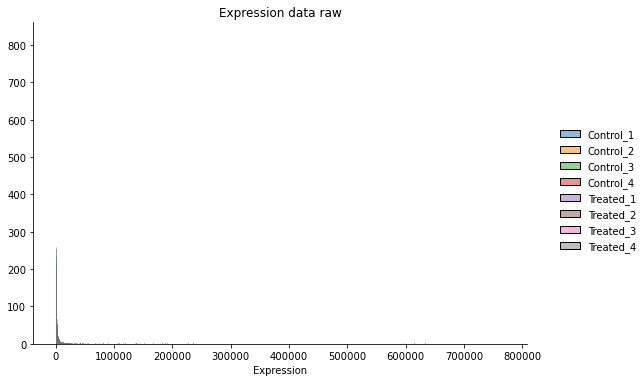

In [5]:
fig=sns.displot(expression,  height=5, aspect=1.6)
plt.title("Expression data raw")
fig.set_axis_labels('Expression', '')


Podemos observar que la visualización de los datos Raw no proporciona información clara, ya que el rango es muy amplio, especificamente de 0 a 80000.

La comparación en este rango tiene muchas limitaciones, incluida la tendencia al sesgo de cálculos hacia numeros grandes.

Uno de los metodos de transformación más comunes aplicados a los datos de microarreglos es la transformación logarítmica.


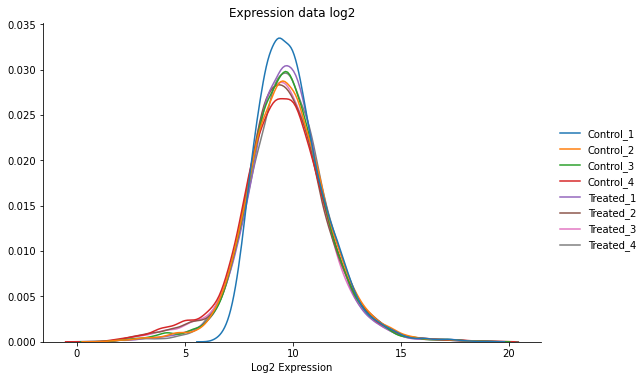

In [6]:
log_expression=np.log2(expression.iloc[:,1:])
fig=sns.displot(log_expression,  kind='kde', height=5, aspect=1.6)
plt.title("Expression data log2")
fig.set_axis_labels('Log2 Expression', '')

Podemos ver la distribución de las muestras limpias. La distribución ahora son comparables y la calidad de los datos es satisfactoria. Ahora podemos ver los boxplos para comparar los quantiles de las muestras.

Text(0, 0.5, 'Log2 Expression')

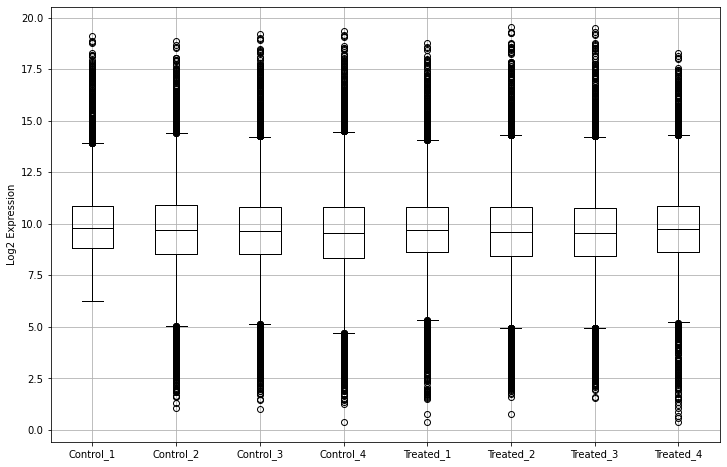

In [7]:
fig, axes = plt.subplots(figsize=(12,8))
ax = log_expression.boxplot(color='k')
ax.set_ylabel('Log2 Expression')

### Normalización

Para comparar los datos, requerimos que las distribuciones sean lo más similares posible sin perder las variaciones entre si, este proceso se llama normalización.

La normalización de cuantiles es uno de los más utilizados para analizar datos de microarreglos.

1. Ordenamos cada columna por los valores mientras hacemos un seguimiento de los valores, específicamente, de qué filas se orginaron los valores.
2. Almacenamos los valores y calculamos el promedio para cada fila.
3. Reemplazamos el valor en cada fila con el valor promedio de cada fila.
4. Volvemos a colocar los valores en sus filas originales.

Esto transforma la nueva matriz de datos normalizados con la suma en todas las columnas.


In [8]:
def quantileNormalize(input):
    temp = input.copy()
    #compute rank
    dic = {}
    for col in temp:
        dic.update({col : sorted(temp[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in temp:
        t = np.searchsorted(np.sort(temp[col]), temp[col])
        temp[col] = [rank[i] for i in t]
    return temp
Norm_samples=quantileNormalize(expression.iloc[:,1:])
Norm_samples

,Control_1,Control_2,Control_3,Control_4,Treated_1,Treated_2,Treated_3,Treated_4
0,1690.3250,957.6500,1399.3875,1148.4500,1567.7625,1657.0000,5001.5625,1915.5625
1,736.6500,492.1250,231.0500,673.5125,426.2500,459.1875,356.2875,239.6375
2,884.4500,896.8250,530.5125,1360.4500,1106.2500,814.8250,1246.3750,935.1875
3,435.7000,678.8625,377.1500,616.9625,210.9375,284.3875,483.1625,286.4875
4,1416.9500,1365.9875,1340.7375,1956.2125,1469.4875,1924.3625,881.1000,1299.6375
...,...,...,...,...,...,...,...,...
16520,338827.9375,338827.9375,338827.9375,338827.9375,300324.4625,338827.9375,319862.6500,319862.6500
16521,300324.4625,284672.4500,319862.6500,319862.6500,272576.7750,308535.5750,300324.4625,272576.7750
16522,573472.2375,573472.2375,573472.2375,573472.2375,573472.2375,573472.2375,573472.2375,573472.2375
16523,458600.5000,458600.5000,458600.5000,458600.5000,458600.5000,458600.5000,458600.5000,458600.5000


Es bastante complicado entender la tabla anterior en términos de las diferencias después de la normalización. Por lo tanto lo mejor es visualizarlo.

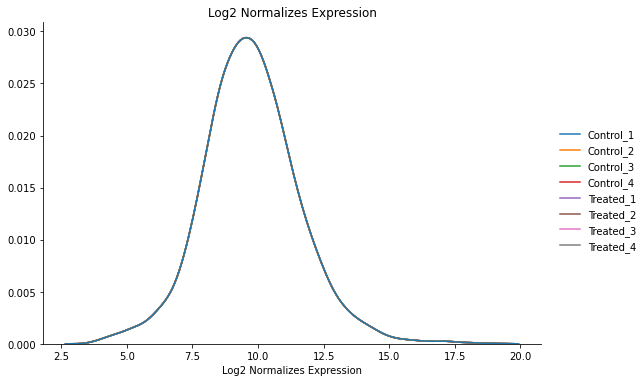

In [9]:
log_norm_expression = np.log2(Norm_samples)
fig=sns.displot(log_norm_expression,  kind='kde', height=5, aspect=1.6)
plt.title("Log2 Normalizes Expression")
fig.set_axis_labels('Log2 Normalizes Expression', '')

Podemos observar que todas las distribuciones son identicas y se sobrelapan una sobre otra despues de la normalización por cuantiles.

Text(0, 0.5, 'Log2 Normalizes Expression’)')

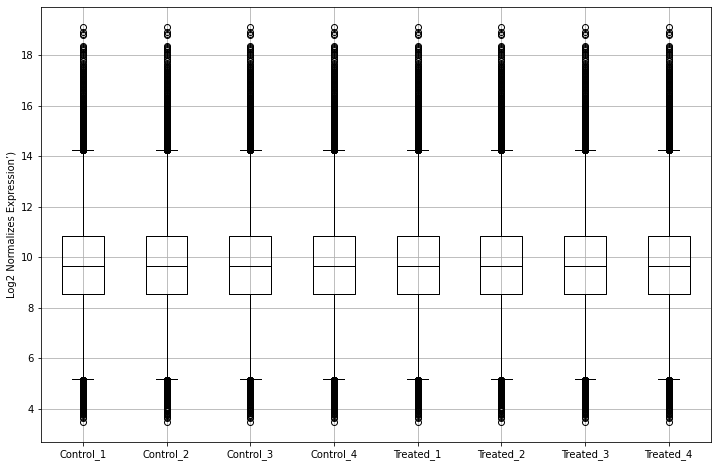

In [10]:
fig, axes = plt.subplots(figsize=(12,8))
ax = log_norm_expression.boxplot(color='k')
ax.set_ylabel('Log2 Normalizes Expression’)')

Podemos observar que todos los cuantiles son iguales.

Normalmente en los microarreglos, los valores de expresión de cada gen se denominan características y las muestras son sus instancias. 
Generalmente ponemos las caracteristicas como columnas y las instancias como filas. Por lo tanto realizaremos la transpuesta de nuestro dataset.


In [11]:
expression_transpose = log_norm_expression.T
expression_transpose.info()
expression_transpose.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, Control_1 to Treated_4
Columns: 16525 entries, 0 to 16524
dtypes: float64(16525)
memory usage: 1.0+ MB


,0,1,2,3,4,5,6,7,8,9,...,16515,16516,16517,16518,16519,16520,16521,16522,16523,16524
Control_1,10.723085,9.524836,9.788637,8.767191,10.468573,8.263621,9.025659,9.553869,6.403225,10.918863,...,15.319744,15.119303,15.219493,16.400238,16.424173,18.370193,18.196162,19.129364,18.806878,6.118941
Control_2,9.903355,8.942881,9.808683,9.406976,10.415729,8.187723,9.523390,8.288001,8.408011,10.262359,...,14.908644,14.987716,15.075847,16.323480,16.292412,18.370193,18.118943,19.129364,18.806878,6.205060
Control_3,10.450580,7.852061,9.051243,8.558995,10.388811,8.257977,8.407162,8.923959,9.059987,10.705935,...,15.424084,15.606708,15.595671,16.696069,16.602807,18.370193,18.287093,19.129364,18.806878,3.954196
Control_4,10.165472,9.395561,10.409868,9.269039,10.933847,9.161478,10.654714,8.357442,8.972908,9.131568,...,15.613680,15.760358,15.743399,16.904966,16.880388,18.370193,18.287093,19.129364,18.806878,5.999154
Treated_1,10.614491,8.735556,10.111462,7.720672,10.521097,9.742730,10.074610,8.486081,8.186548,9.689845,...,15.186129,15.251928,15.319744,14.816864,14.792094,18.196162,18.056303,19.129364,18.806878,6.329348


Nuestro dataset tiene ocho filas y 16525 columnas, esto es un ejemplo de datos de alta dimensión es decir este conjunto tiene 16525 dimensiones.

Utilizaremos PCA para reducir su dimensión para visualizar los puntos de datos en un espacio 2D.

El primer paso es escalar los datos restando las medias y luego dividiendo esto por la desviación estandar.


In [13]:
#Estandarización
#Vamos a escalar los valores
expression_transpose_std = (expression_transpose-expression_transpose.mean()
                           )/expression_transpose.std()
#A veces, con datos reales, al escalar podemos obtener valores infinitos mientras dividimos con la desviación estandar
#En estos casos es probable que tengamos que excluir esos valores de nuesto dataset
#Por lo tanto vamos a convertit los valores infinitos en "NaN" y posteriormente los eliminamos usando ".dropna()"
expression_transpose_std = expression_transpose_std.replace(
    [np.inf, -np.inf], np.nan)
expression_transpose_std = expression_transpose_std.dropna(axis=1)



In [14]:
#Ahora implementaremos PCA
sklearn_pca = PCA(n_components=2)
print(expression_transpose_std.shape)
PCs = sklearn_pca.fit_transform(expression_transpose)
print(PCs.shape)
print(sklearn_pca.explained_variance_ratio_)

(8, 16523)
(8, 2)
[0.20351873 0.18757078]


Podemos observar que que el conjunto de datos de 8 x 16525, se redujo a un dataset de 8 x 16523, de manera que se descartaron dos porque producían valores infinitos durante el escalado.

Posteriomente al PCA, la dimension de nuestro dataset es de 8x2, esto conserva alrededor del 39% de las variaciones.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

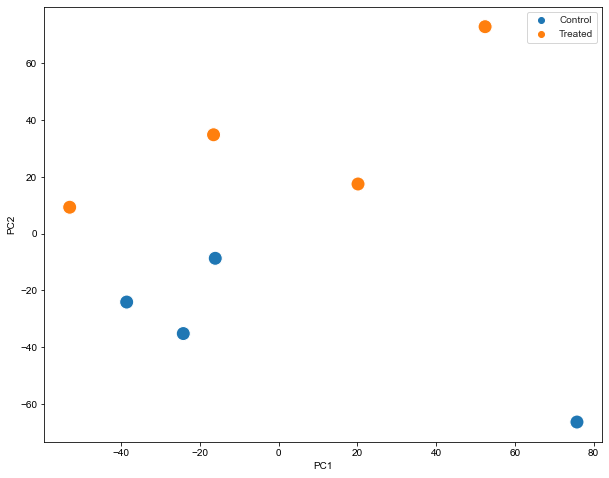

In [15]:
expression_PCs = pd.DataFrame(PCs,columns=['PC1','PC2'])
expression_PC1 = expression_PCs.set_index(np.array((['Control']*4)+['Treated']*4))
expression_PC2 = expression_PCs.set_index(expression_transpose.index)
fig, axes = plt.subplots(figsize=(10,8))
sns.set_style('whitegrid')
sns.scatterplot(x='PC1',y='PC2',data = expression_PC2, hue =expression_PC1.index, s=200)

El grafico de dos dimensiones contien una varianza del 39%, Podemos observar que los datos de control y tratamiento pueden separarse a través de una línea paralela a PC1 que pasa por el origen de PC2. 

Esto implican que los grupos de control y los grupos tratados son diferentes, y los datos son adecuados para observar las disparidades entre ellos para encontrar genes expresados diferencialmente.

En muchos casos, la visualización de PCA mostrará grupos de valores de control y tratados colocados claramente uno al lado del otro, lo que también implica que los datos son aplicables para un análisis posterior.

## Analisis de expresión diferencial

Para descubrir los genes expresados diferencialmente, se comparan los valores promedio de los grupos de control y tratamiento para cada gen, para análizar si el gen del tratamiento esta upregulated o downregulated con respecto al gen control.
La validación estadistica de esta comparación es por medio de una prueba estadistica llamada t de student.

La prueba t se utiliza para comparar medias de muestas. Proporciona un valor p, que es la probabilidad estimada de rechazar la hipótesis nula. Por lo tanto, un valor p más bajo implica que existe una diferencia signifiativa entre las expresiones de un gen en dos conjuntos de datos. Un valor de P inferior a 0.05 es estadísticamente significativo.

Después de determinar que la expresión génetica es significativamente diferente entre los conjuntos de muestras, calculamos el cambio en la expresión restando los valores transformados log2 de las intensidades del control con el tratamiento, o el cambio Log2 Fold. Si el resultado es un valor positivo se dice que el gen esta upregulated. Por el contrario si el resultado es negativoa, entonces se llamaría downregulated. 

In [16]:
from scipy import stats
control_mean = log_norm_expression.iloc[:,:4].mean(axis=1)
treated_mean = log_norm_expression.iloc[:,4:].mean(axis=1)

compair_means=pd.DataFrame(columns=['Control_Mean','Treated_mean'])
compair_means['Control_Mean']=control_mean
compair_means['Treated_mean']=treated_mean
compair_means['log2_fold_change'] = (compair_means['Treated_mean']-
                                     compair_means['Control_Mean'])
                                     

t_tset_values = pd.DataFrame(stats.ttest_ind(
    log_norm_expression.iloc[:,:4],log_norm_expression.iloc[:,4:],axis=1)).T

t_tset_values.columns = ['Stastics','Pvalue']

compair_means = pd.concat([expression.iloc[:,0],compair_means,t_tset_values],axis=1)
compair_means.head()


,ID_REF,Control_Mean,Treated_mean,log2_fold_change,Stastics,Pvalue
0,1007_s_at,10.310623,11.125141,0.814518,-1.891712,0.107397
1,121_at,8.928835,8.490026,-0.438809,1.011076,0.351002
2,1316_at,9.764608,9.983611,0.219003,-0.708891,0.504990
3,1552257_a_at,9.000550,8.237770,-0.762780,2.384782,0.054412
4,1552264_a_at,10.551740,10.389579,-0.162161,0.607118,0.566024


In [17]:
#Ahora uniremos lestos datos con la tabla de anotación
merged_table = pd.merge(annotation,compair_means,on='ID_REF')
merged_table.head()

,ID_REF,GB_ACC,Gene Symbol,ENTREZ_GENE_ID,Control_Mean,Treated_mean,log2_fold_change,Stastics,Pvalue
0,1007_s_at,U48705,DDR1 /// MIR4640,780 /// 100616237,10.310623,11.125141,0.814518,-1.891712,0.107397
1,121_at,X69699,PAX8,7849,8.928835,8.490026,-0.438809,1.011076,0.351002
2,1316_at,X55005,THRA,7067,9.764608,9.983611,0.219003,-0.708891,0.504990
3,1552257_a_at,NM_015140,TTLL12,23170,9.000550,8.237770,-0.762780,2.384782,0.054412
4,1552264_a_at,NM_138957,MAPK1,5594,10.551740,10.389579,-0.162161,0.607118,0.566024


In [18]:
#El siguiente paso es filtrar las filas con genes que están significativamente upregulated o downregulated con valor p ≤ 0.05

significant_table = merged_table[merged_table['Pvalue']<=0.05]
significant_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 23 to 16496
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_REF            1251 non-null   object 
 1   GB_ACC            1250 non-null   object 
 2   Gene Symbol       1119 non-null   object 
 3   ENTREZ_GENE_ID    1100 non-null   object 
 4   Control_Mean      1251 non-null   float64
 5   Treated_mean      1251 non-null   float64
 6   log2_fold_change  1251 non-null   float64
 7   Stastics          1251 non-null   float64
 8   Pvalue            1251 non-null   float64
dtypes: float64(5), object(4)
memory usage: 97.7+ KB


In [18]:
significant_table.head()

,ID_REF,GB_ACC,Gene Symbol,ENTREZ_GENE_ID,Control_Mean,Treated_mean,log2_fold_change,Stastics,Pvalue
23,1552439_s_at,NM_032445,MEGF11,84465,7.142332,7.819578,0.677245,-3.219326,0.018153
25,1552455_at,NM_138818,PRUNE2,158471,7.957190,8.936062,0.978872,-3.187801,0.018889
29,1552498_at,NM_145238,ZSCAN20,7579,7.676399,8.627494,0.951095,-2.671490,0.036953
45,1552627_a_at,NM_001173,ARHGAP5,394,9.822314,10.425121,0.602807,-2.642834,0.038395
47,1552656_s_at,NM_144624,UHMK1,127933,9.814447,8.865032,-0.949415,3.759277,0.009407


Obtuvimos 1251 genes de este tipo que se expresan de manera diferencial significativamente. A continuación, colocamos un límite en los valores de log2 fold change para producir valores más estrictos. Este corte depende de los experimentos y resultados y puede variar entre ±1 y ±2. En este paso, tomamos ±1,5 (es decir, más de 1,5 y menos de −1,5) log2 veces el cambio.

In [19]:
Upregulated_genes = significant_table[
    significant_table['log2_fold_change']>1.5]
Downregulated_genes = significant_table[
    significant_table['log2_fold_change']<-1.5]
print('Upregulated Genes')
Upregulated_genes.info()
print('\nDownregulated Genes')
Downregulated_genes.info()

Upregulated Genes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 136 to 16178
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_REF            69 non-null     object 
 1   GB_ACC            69 non-null     object 
 2   Gene Symbol       47 non-null     object 
 3   ENTREZ_GENE_ID    46 non-null     object 
 4   Control_Mean      69 non-null     float64
 5   Treated_mean      69 non-null     float64
 6   log2_fold_change  69 non-null     float64
 7   Stastics          69 non-null     float64
 8   Pvalue            69 non-null     float64
dtypes: float64(5), object(4)
memory usage: 5.4+ KB

Downregulated Genes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 71 to 16262
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_REF            63 non-null     object 
 1   GB_ACC            63 non-null    

Obtenemos 69 genes upregulated y 63 downregulated. Ahora consolidadmos la tabla de genes expresados diferencialmente.

In [20]:
DEGs = pd.concat([Upregulated_genes,Downregulated_genes])
DEGs.head()

,ID_REF,GB_ACC,Gene Symbol,ENTREZ_GENE_ID,Control_Mean,Treated_mean,log2_fold_change,Stastics,Pvalue
136,1553253_at,NM_080863,ASB16,92591,7.767619,9.307180,1.539562,-3.317525,0.016054
235,1553954_at,BU682208,ALG14,199857,6.503933,8.086674,1.582741,-2.476600,0.048026
259,1554043_a_at,BC012528,NaN,NaN,6.857222,8.667420,1.810198,-2.667561,0.037147
381,1554772_at,BC036407,EFCAB13,124989,8.644272,10.226655,1.582383,-2.905322,0.027145
425,1555118_at,BC029869,ENTPD3,956,5.923432,7.722591,1.799159,-3.371086,0.015022


### Ahora vamos a recuperar los datos de expresión utilizando los genes diferencialmente expresados

In [21]:
log_expression=pd.concat([expression.iloc[:,0],log_expression],axis=1)
table = pd.merge(DEGs.iloc[:,:3],log_expression,on='ID_REF')
table=table.drop(['ID_REF', 'GB_ACC'], axis=1)
table.head()

,Gene Symbol,Control_1,Control_2,Control_3,Control_4,Treated_1,Treated_2,Treated_3,Treated_4
0,ASB16,8.163398,7.315602,7.305606,8.657140,9.642052,8.896332,9.869440,8.719047
1,ALG14,7.779391,7.172927,3.944858,6.507795,7.837943,8.327777,8.751544,7.235536
2,NaN,8.587215,7.062856,6.277985,4.336283,8.104861,8.756223,9.707532,7.955940
3,EFCAB13,8.820179,9.316734,9.170426,7.210428,9.704077,10.421329,11.122569,9.643676
4,ENTPD3,7.830990,4.209453,6.137504,4.078951,7.001127,7.326429,8.431289,7.835419


Este dataset conserva la columna de numeros asociados del GenBank y las ocho columnas de los valores de expresión, cuatro de control y cuatro de muestras tratadas. Este contiene 132 genes.

In [22]:
table.describe()

,Control_1,Control_2,Control_3,Control_4,Treated_1,Treated_2,Treated_3,Treated_4
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,9.070583,8.508938,8.248652,8.055377,8.402029,8.117435,8.295692,8.542134
std,1.278072,1.767599,2.001190,2.197749,2.200985,2.345779,2.321438,2.100473
min,6.685099,3.277985,1.722466,2.485427,1.887525,2.201634,2.201634,2.104337
25%,8.120952,7.395747,7.269044,6.651550,7.097323,6.638132,6.978917,7.448343
50%,8.827167,8.312169,8.144647,8.276980,8.735816,8.513519,8.680008,8.907190
75%,9.985888,9.699045,9.618288,9.548193,9.843254,9.802632,9.870595,9.726872
max,12.353533,12.883617,12.502359,12.716798,12.905443,13.301425,13.024049,12.892391


In [23]:
#verificamos que no tenga valores nulos.
table.isna().sum()

Gene Symbol    26
Control_1       0
Control_2       0
Control_3       0
Control_4       0
Treated_1       0
Treated_2       0
Treated_3       0
Treated_4       0
dtype: int64

In [24]:
#Vamos a separar los valores de expresión de las muestras de tratamiento
new_data=table.iloc[:,5:]
new_data.head()

,Treated_1,Treated_2,Treated_3,Treated_4
0,9.642052,8.896332,9.869440,8.719047
1,7.837943,8.327777,8.751544,7.235536
2,8.104861,8.756223,9.707532,7.955940
3,9.704077,10.421329,11.122569,9.643676
4,7.001127,7.326429,8.431289,7.835419


### Ahora necesitamos determinael el valor optimo de K, utilizando el método elbow


Para elegir el valor óptimo de k-means, entrenaremos el algoritmo con diferentes valores de k-means mientras observamos la suma de cuadrados dentro del grupo (within-cluster-sum-of-squares (WCSS)). La distancia de los puntos a su centroide se calcula y eleva al cuadrado. Despues, se suman todas las distancias al cuadrado para calcular el error. 

A medida que aumenta el valor de k, el error disminuye. A partir de la grafica WCSS versus el valor k, podemos encontrar el valor k óptimo.


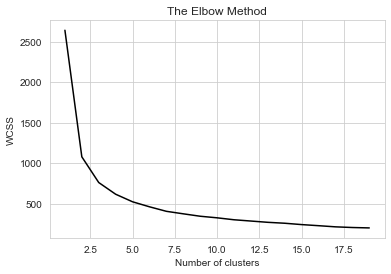

In [25]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 150)
    kmeans.fit(new_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss,color='k')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

A partir de la grafica de elbow, podemos observar que la pendiente del error permanece casi igual después de llegar a ocho. 

In [26]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8,init = 'k-means++')
kmeans.fit(new_data)

KMeans()

In [27]:
#Podemos recuperar los centrode los cluster. 
kmeans.cluster_centers_

array([[ 7.94546857,  7.53758454,  8.0605358 ,  8.66677601],
       [10.18500471, 10.14576102, 10.22463969, 10.15703167],
       [ 7.02626602,  7.22028441,  5.19465503,  7.21263092],
       [ 3.83570502,  4.31546584,  4.23884281,  6.1455344 ],
       [ 6.31310027,  4.96887592,  7.27585163,  7.19784578],
       [ 6.29865085,  5.16860873,  5.03935111,  3.58835589],
       [12.16296061, 11.98612974, 12.0191198 , 11.98039436],
       [ 9.12005264,  8.91213099,  9.12754233,  9.06726891]])

In [28]:
kmeans.labels_

array([7, 0, 7, 1, 0, 1, 6, 7, 6, 7, 4, 7, 7, 1, 1, 7, 7, 1, 7, 7, 1, 4,
       7, 6, 6, 1, 1, 7, 7, 1, 1, 2, 1, 7, 7, 7, 7, 7, 7, 6, 1, 6, 0, 7,
       7, 1, 1, 0, 7, 6, 0, 7, 1, 1, 1, 1, 7, 7, 1, 7, 7, 1, 6, 1, 7, 0,
       7, 2, 6, 3, 1, 2, 2, 4, 5, 3, 3, 2, 5, 7, 5, 2, 4, 1, 7, 4, 5, 0,
       0, 0, 5, 4, 1, 7, 3, 3, 5, 0, 4, 0, 1, 0, 1, 5, 0, 7, 4, 2, 1, 2,
       0, 0, 0, 3, 5, 7, 7, 0, 0, 4, 4, 4, 1, 2, 4, 0, 2, 3, 2, 3, 5, 3],
      dtype=int32)

En el siguiente paso, asignaremos los números de conglomerados recuperados del paso anterior a los ID de acceso de GenBank.

In [29]:
cluster_genes =pd.concat([table.iloc[:,0],pd.DataFrame(kmeans.labels_)],axis=1)
cluster_genes.columns= ['Gene Symbol','Groups']
cluster_genes.head()

,Gene Symbol,Groups
0,ASB16,7
1,ALG14,0
2,NaN,7
3,EFCAB13,1
4,ENTPD3,0


In [30]:
#Vamos a agrupar los los genes en sus respectivo cluster, utilizando la función gruopby
cluster = cluster_genes.groupby('Groups')
cluster.describe()

Gene Symbol                       
             count unique        top freq
Groups                                   
0               18     18      ALG14    1
1               21     21    EFCAB13    1
2                8      8      OLFM3    1
3                7      7      HDAC9    1
4               11     11     HIVEP1    1
5                9      9       BIN3    1
6                7      7  LOC441081    1
7               25     25      ASB16    1

Podemos observar que el cluster 7 es el que tiene el mayor número de genes. Vamos a recuperar los elemtnos de cluster 7.

In [32]:
cluster = {k: v for k, v in cluster_genes.groupby('Groups')}
cluster[7]

,Gene Symbol,Groups
0,ASB16,7
2,NaN,7
7,NaN,7
9,NaN,7
11,NaN,7
12,LLNLR-246C6.1,7
15,LITAF,7
16,BHLHE40,7
18,NAIP,7
19,ATF2,7


In [33]:
cluster2=cluster[5]
gene_list=cluster2['Gene Symbol'].values.tolist()
gene_list=[element for element in gene_list if str(element) != "nan"]
print(gene_list)

['BIN3', 'ABHD1', 'AP3B2', 'FBLN1', 'EIF1AY', 'LDHC', 'PLAC8', 'MYH11', 'RP11-250B2.3']


La biblioteca gseapy tiene un método llamado "enrichr ()": utiliza principalmente una lista de genes expresados ​​diferencialmente, el organismo, la base de datos de la lista o la biblioteca en la que preferimos buscar, el valor p de corte y el directorio donde queremos guardar los resultados. La lista de bases de datos se puede encontrar en “https://amp.pharm.mssm.edu/Enrichr/#stats” o aplicando un método llamado “gp.get_library_name()”. Los cinco principales procesos biológicos afectados por nuestros cluster se muestran en la Tabla

In [34]:
import gseapy as gp

enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 
                 outdir='test/enrichr_kegg',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results[['Gene_set','Term','Overlap','P-value','Genes']].head()

,Gene_set,Term,Overlap,P-value,Genes
0,GO_Biological_Process_2021,medium-chain fatty acid catabolic process (GO:...,1/5,0.002248,ABHD1
1,GO_Biological_Process_2021,medium-chain fatty acid biosynthetic process (...,1/6,0.002697,ABHD1
2,GO_Biological_Process_2021,skeletal myofibril assembly (GO:0014866),1/8,0.003595,MYH11
3,GO_Biological_Process_2021,elastic fiber assembly (GO:0048251),1/8,0.003595,MYH11
4,GO_Biological_Process_2021,negative regulation of substrate adhesion-depe...,1/13,0.005836,FBLN1


In [35]:
from gseapy import barplot, dotplot

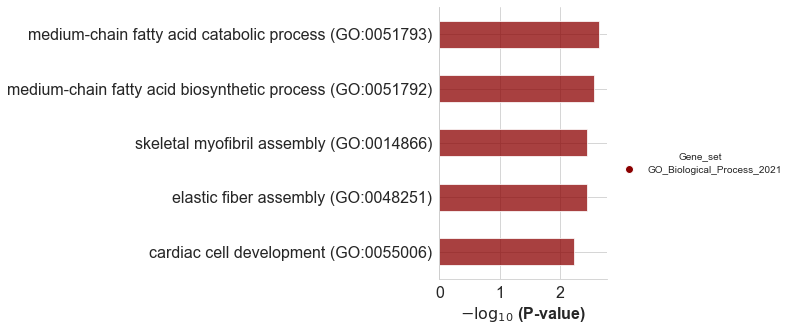

In [36]:
ax = barplot(enr.results,
              column="P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              color=['darkred'] # set colors for group
             )